In [1]:
using StochasticEuler
using PyPlot
PyPlot.plt[:style][:use]("ggplot")

# Documentation

In [2]:
?ieuler_sde

search: 

## ieuler_sde()

Solve an SDE using the implicit stochastic euler method and return the states `xs` at each point in the time grid `ts`. The method also returns the noise increments `dWs` for each integration interval. The SDE is assumed to be given by

\begin{align}   dx(t) = f(t,x(t)) dt + g(t,x(t)) dW \end{align}

where the type of the SDE (Ito/Stratonovich) must be specified as the the first function argument.

The sde is passed as a function `sde!(t, x, f, gdW, dW, compute_f, compute_gdW)` that writes the drift term of `x` at time `t` into a vector `f` and the diffusion term into a vector `gdW`. The noise increments at time `t` are passed as a vector `dW`. Two additional boolean flags `compute_f` and `compute_gdW` specify whether to compute `f` or `gdW` in a given `sde!()` call. This allows to save work. The solver also calls `sde!` after each success integration step with both `compute_f=compute_gdW=false`. The `sde!` function can use this as a callback mechanism to carry out useful cleanup work on `x` itself before `x` is appended to the result.

The initial state is `x0`. The time grid at which the states are returned is `ts`, the maximum stepsize to be used is `hmax`.

At each time step the method solves the following non-linear system of equations for x(t+h):

\begin{align}   x(t+h) == x(t) + [(1-ν) f(t, x(t)) + ν f(t+h, x(t+h))] h + ΔB(x(t),ΔW(t)) \end{align}

where the diffusion term is given by:

```
ΔB(x(t),ΔW) := g(t, x(t)) ΔW                         (for Ito SDEs)
ΔB(x(t),ΔW) := (1/2)[g(t, x(t)) + g(t, y(t))] ΔW     (for Stratonovich SDEs)
  where y(t) := x(t) + g(t,x(t)) ΔW
```

This is achieved by a damped pseudo-Newton iteration with the initial guess provided by the standard forward Euler step. Optional keyword parameters are:

  * ν: relative weight of start / end-point combination (default ν=.5)
  * κ: damping factor for pseudo-Newton iteration (default κ=.8)
  * ϵ_rel: relative error tol. in pseudo-Newton iteration (default ϵ_rel=1e-3)
  * max_iter: maximum number of Newton iterations (default max_iter=5)
  * verbose: print messages (default = true)
  * rng: An AbstractRNG instance to sample the noise increments from
  * seed: A seed for the RNG.
  * verbose: Print status messages (default = false)


# Examples
## Testcase 1: Ornstein Uhlenbeck

ieuler_sde ieuler_heun ieuler_mayurama



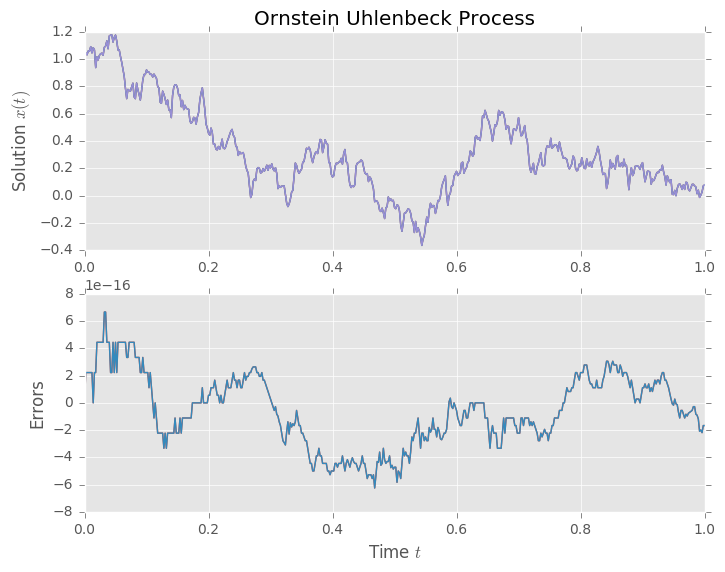

PyObject <matplotlib.text.Text object at 0x31dbe4438>

In [3]:
σ = 1.
θ = 0.
μ = 0.

function ornstein_uhlenbeck!(t, x, xdot, gdW, dW, compute_xdot, compute_gdW)
    if compute_xdot
        xdot[:]=θ*(μ-x[1])
    end
    if compute_gdW
        gdW[1] = σ*dW[1]
    end
    xdot, gdW
end

t0=0
t1=1.
ts = linspace(t0,t1,501)

h = .001
x0 = [1.]

# Since the diffusion coefficient is constant, the Ito and Stratonovich SDEs are identical
ts, xs1, dWs = ieuler_heun(ornstein_uhlenbeck!, x0, ts, h, 1)
ts, xs2, dWs = ieuler_mayurama(ornstein_uhlenbeck!, x0, ts, h, 1)


expmtht = exp(-θ*ts)
sol = x0[1] *expmtht - μ*(expmtht-1) +  σ*expmtht .* cumsum([0;dWs']./expmtht);

subplot(211)
plot(ts, xs1')
plot(ts, xs2')
plot(ts, sol)
ylabel(L"Solution $x(t)$")
title("Ornstein Uhlenbeck Process")
subplot(212)
plot(ts, xs1'-sol)
plot(ts, xs2'-sol)
xlabel(L"Time $t$")
ylabel("Errors")


## Testcase 2: General linear SDE

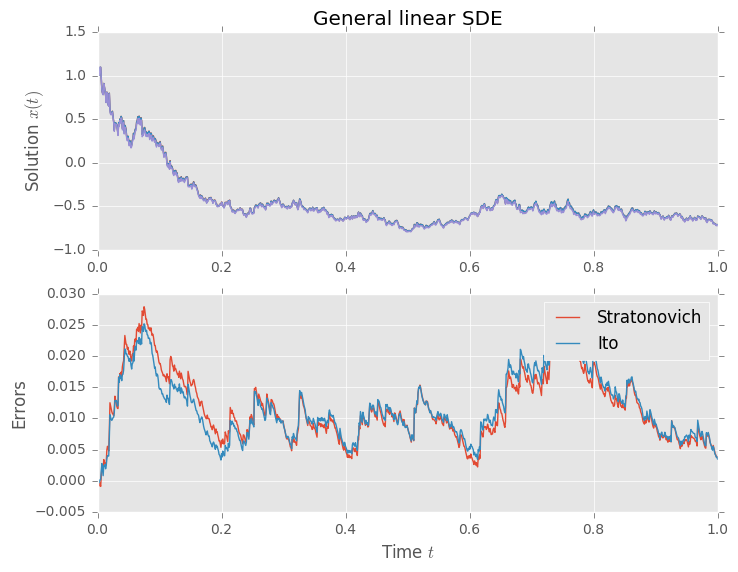

PyObject <matplotlib.text.Text object at 0x31de6ea58>

In [4]:
a, b, c, d = randn(4)

function linear_sde_ito!(t, x, xdot, gdW, dW, compute_xdot, compute_gdW)
    if compute_xdot
        xdot[1]=(a*x[1] + c)
    end
    if compute_gdW
        gdW[1] = (b*x[1] + d) * dW[1]
    end
    xdot, gdW
end

function linear_sde_strat!(t, x, xdot, gdW, dW, compute_xdot, compute_gdW)
    if compute_xdot
        xdot[1]=((a-.5*b^2)*x[1] + c - .5*b*d)
    end
    if compute_gdW
        gdW[1] = (b*x[1]+d)*dW[1]
    end
    xdot, gdW
end


t0=0
t1=1.
ts = linspace(t0, t1, 1001)
h = .0001
x0 = [1.]
ts, xs1, dWs = ieuler_heun(linear_sde_strat!, x0, ts, h, 1)
ts, xs2, dWs = ieuler_mayurama(linear_sde_ito!, x0, ts, h, 1)

dts = diff(ts)
dWs = dWs'
Φtt0 = exp(cumsum((a-.5*b^2) * dts + b*dWs))
xtsol = [x0[1]; Φtt0 .* (x0[1] + cumsum((c) *dts ./ Φtt0)  + cumsum(d * dWs ./ Φtt0))]

subplot(211)
title("General linear SDE")
plot(ts, xs1')
plot(ts, xs2')
plot(ts, xtsol)
ylabel(L"Solution $x(t)$")


subplot(212)
plot(ts, xs1'-xtsol, label="Stratonovich")
plot(ts, xs2'-xtsol, label="Ito")
legend()
xlabel(L"Time $t$")
ylabel("Errors")




## Testcase 3: Exponential SDE

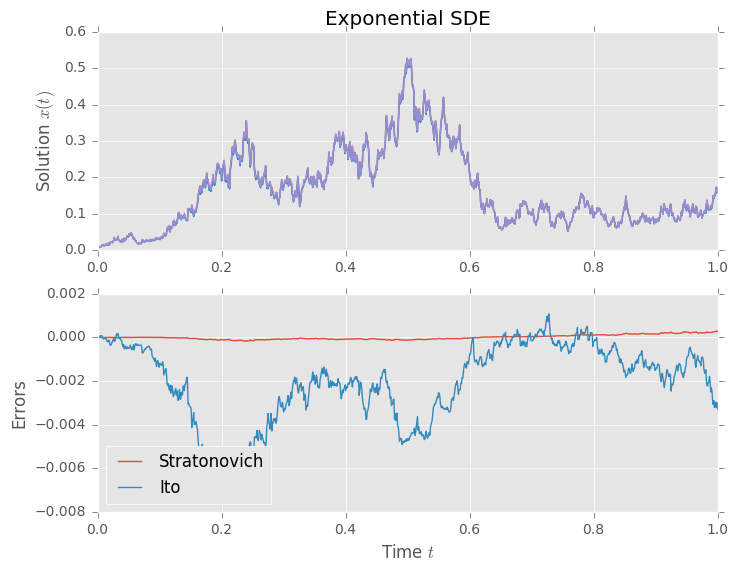

PyObject <matplotlib.text.Text object at 0x31e8b2550>

In [5]:

function exp_sde_ito!(t, x, xdot, gdW, dW, compute_xdot, compute_gdW)
    if compute_xdot
        xdot[1]= -x[1]*(2*log(x[1]) + 1)
    end
    if compute_gdW
        gdW[1] = -2x[1]*sqrt(-log(x[1]))*dW[1]
    end
    xdot, gdW
end

function exp_sde_strat!(t, x, xdot, gdW, dW, compute_xdot, compute_gdW)
    if compute_xdot
        xdot[1]= 0.
    end
    if compute_gdW
        gdW[1] = -2x[1]*sqrt(-log(x[1]))*dW[1]
    end
    xdot, gdW
end

t0=0
t1=1.
ts = linspace(t0, t1, 1001)
h = .0001
x0 = [.01]

ts, xs1, dWs = ieuler_heun(exp_sde_strat!, x0, ts, h, 1; ν=.5)
ts, xs2, dWs = ieuler_mayurama(exp_sde_ito!, x0, ts, h, 1; ν=.5)


dts = diff(ts)
dWs = dWs'
Wts = cumsum(dWs)

xtsol = [x0[1]; exp(-(Wts + sqrt(-log(x0[1]))).^2)]

subplot(211)
title("Exponential SDE")
plot(ts, xs1')
plot(ts, xs2')
plot(ts, xtsol)
ylabel(L"Solution $x(t)$")


subplot(212)
plot(ts, xs1'-xtsol, label="Stratonovich")
plot(ts, xs2'-xtsol, label="Ito")
legend(loc="lower left")
xlabel(L"Time $t$")
ylabel("Errors")

# Stochastic convergence

In [6]:
?CumulativeNormal

search: 

## CumulativeNormal

Helper type for sampling coarse grained realizations of a d-dimensional Brownian motion. It takes as an existing `rng` whose samples corresponds to the minimum grid size and yields sums over `N` variables sampled from `rng` spaced at a dimension `D` and renormalizes them.

This type is not optimized for efficiency and should only be used to verify stochastic convergence properties.

For convenience, complex random normals are supported as well. A `CumulativeNormal` rng should only be used to generate fixed length vectors of real or complex normal variables `[x1,...,xD]` at a time.

When the type parameter is `N`, it sums `N` random variables for every output variable such that if the underlying rng samples

```
[ x11 x12 ... x1N  
  x21 x22 ... x2N  
  ...  
  xD1 xD2 ... XDN ]
```

then the `CumulativeNormal` rng sums over each row and renormalizes by `1/sqrt(N)` to produce a `D` dimensional vector of real/complex normal variables.


CumulativeNormal



## Test the CumulativeNormal RNG

In [33]:
d = 5
rng = MersenneTwister()

# averages over 2 samples
cnrng2 = CumulativeNormal(rng, 2,d)

# averages over 4 samples
cnrng4 = CumulativeNormal(rng, 4,d)

vec = zeros(d)
srand(rng, 0)
full_grid = hcat([randn(rng, d) for j=1:4]...)
srand(rng, 0)
half_grid = hcat([randn(cnrng2, d) for j=1:2]...)
srand(rng, 0)
quarter_grid = hcat([randn!(cnrng4, vec) for j=1:1]...)

# Verify that block summing works correctly
@assert norm(full_grid * kron(eye(2), ones(2))/sqrt(2) - half_grid) < 10*eps(Float64)
@assert norm(full_grid * ones(4)/sqrt(4) - quarter_grid) < 10*eps(Float64)
@assert norm(half_grid * ones(2)/sqrt(2) - quarter_grid) < 10*eps(Float64)

## Simulate SDE for same stochastic realization at different grid sizes

In [61]:
t0=0
t1=1.
ts = linspace(t0, t1, 501)
h = .00001
x0 = [.01]

d = 1
rng = MersenneTwister()

# averages over 2 samples
cnrng2 = CumulativeNormal(rng, 2,d)


# averages over 4 samples
cnrng4 = CumulativeNormal(rng, 4,d)

# averages over 8 samples
cnrng8 = CumulativeNormal(rng, 8,d)

seed = 2

ts, xs1, dWs = ieuler_heun(linear_sde_strat!, x0, ts, h, 1; rng=rng, ν=.5, seed=seed)
ts, xs2, dWs2 = ieuler_heun(linear_sde_strat!, x0, ts, h*2, 1; rng=cnrng2, ν=.5, seed=seed)
ts, xs4, dWs4 = ieuler_heun(linear_sde_strat!, x0, ts, h*4, 1; rng=cnrng4, ν=.5, seed=seed)
ts, xs8, dWs8 = ieuler_heun(linear_sde_strat!, x0, ts, h*8, 1; rng=cnrng8, ν=.5, seed=seed)

dts = diff(ts)
dWs = dWs'
Φtt0 = exp(cumsum((a-.5*b^2) * dts + b*dWs))
xtsol = [x0[1]; Φtt0 .* (x0[1] + cumsum((c) *dts ./ Φtt0)  + cumsum(d * dWs ./ Φtt0))];


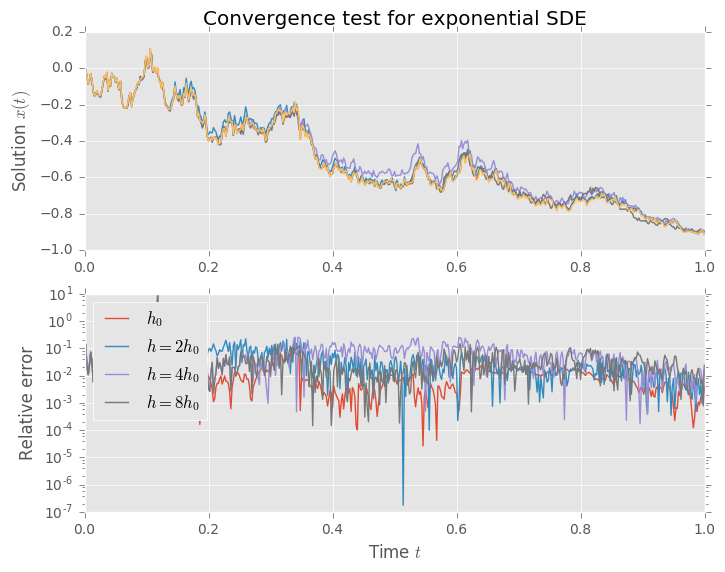

PyObject <matplotlib.text.Text object at 0x3237ebcf8>

In [62]:
subplot(211)

plot(ts, xs1', label="h=$h")
plot(ts, xs2', label="h=$(2h)")
# plot(ts, xs3', label="h=$(3h)")
plot(ts, xs4', label="h=$(4h)")
plot(ts, xs8', label="h=$(8h)")
plot(ts, xtsol, label="exact")

# legend(loc="upper right")
title("Convergence test for exponential SDE")
ylabel(L"Solution $x(t)$")
subplot(212)
rel_err1 = abs(xs1'-xtsol)./abs(xtsol)
rel_err2 = abs(xs2'-xtsol)./abs(xtsol)
# rel_err3 = abs(xs3'-xtsol)./abs(xtsol)
rel_err4 = abs(xs4'-xtsol)./abs(xtsol)
rel_err8 = abs(xs8'-xtsol)./abs(xtsol)
semilogy(ts, rel_err1, label=L"h_0")
semilogy(ts, rel_err2, label=L"h=2h_0")
# semilogy(ts, rel_err3, label=L"h=3h_0")
semilogy(ts, rel_err4, label=L"h=4h_0")
semilogy(ts, rel_err8, label=L"h=8h_0")
legend(loc="lower left")
xlabel(L"Time $t$")
ylabel("Relative error")